In [1]:
%matplotlib inline
from pathlib import Path
from enum import Enum
from collections import namedtuple
from dataclasses import dataclass
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
hep.set_style(hep.styles.CMS)

In [3]:
REGION_LAYER_LIST = [
    (-1, 2),
    (-1, 1),
    (1, 1),
    (1, 2)
]

NUM_CHAMBERS = 36

RUN_HV680_START = 343389

In [4]:
plot_dir = Path("./plots")

In [5]:
def make_title(region, layer):
    return f"GE11-{'P' if region > 0 else 'M'}-L{layer}"

In [6]:
def to_hour(value):
    value = pd.to_datetime(value, format="%H:%M:%S")
    return value.hour

In [7]:
oms = pd.read_csv("./data/oms.csv")
oms.head()

,run,duration,start,end
0,343774,11:02:04,2021-07-26 19:29:39,2021-07-27 6:31:43
1,343772,0:25:25,2021-07-26 19:01:41,2021-07-26 19:27:06
2,343769,0:14:32,2021-07-26 18:42:57,2021-07-26 18:57:29
3,343767,1:06:32,2021-07-26 17:34:54,2021-07-26 18:41:26
4,343763,0:07:34,2021-07-26 17:13:23,2021-07-26 17:20:57


In [8]:
def get_hour(run):
    duration = oms[oms.run == run].duration.to_list()[0]
    duration = pd.to_datetime(duration, format="%H:%M:%S")
    return duration.hour

In [9]:
@dataclass
class EffBand:
    x: List[float]
    ylow: List[float]
    yup: List[float]

In [10]:
def make_eff_band(data):
    gby = data.groupby('chamber')
    ylow = gby.eff.min()
    yup = gby.eff.max()

    x = ylow.index.to_list()

    return EffBand(x, ylow, yup)

In [11]:
def plot_fill_between(data, label, color, ax=None):
    if ax is None:
        ax = plt.gca()
        
    gby = data.groupby('chamber')
    ylow = gby.eff.min()
    yup = gby.eff.max()
    x = ylow.index.to_list()
    y = gby.eff.mean()

    ax.fill_between(x, ylow, yup, color=color, label=label, alpha=0.2, interpolate=False)
    ax.plot(x, y, color=color, ls=':', marker='s', lw=3)
    
    ax.plot(x, ylow, alpha=0.5, color=color, ls='-', lw=3)
    ax.plot(x, yup, alpha=0.5, color=color, ls='-', lw=3)

In [12]:
data_path = Path("./data/Cosmics.csv")
df = pd.read_csv(data_path)
hour = df.run.apply(get_hour)
df.insert(1, "hour", hour)

# in hour
min_duration = 5

# remove 
df = df[df.status == 1]
df = df[df.hour >= min_duration]

In [13]:
df.head()

,run,hour,region,layer,chamber,status,total,passed,eff,eff_low,eff_up
0,342728,10,1,2,1,1,157,126,0.802548,0.765543,0.835326
1,342728,10,1,2,2,1,354,285,0.805085,0.781708,0.826624
2,342728,10,1,2,3,1,227,183,0.806167,0.776297,0.833120
3,342728,10,1,2,4,1,379,240,0.633245,0.606820,0.658930
4,342728,10,1,2,5,1,411,358,0.871046,0.852326,0.887830


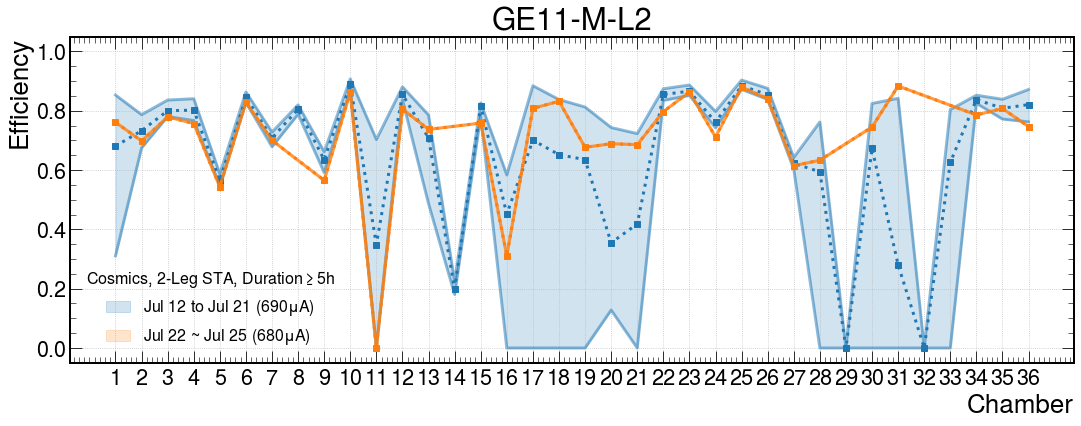

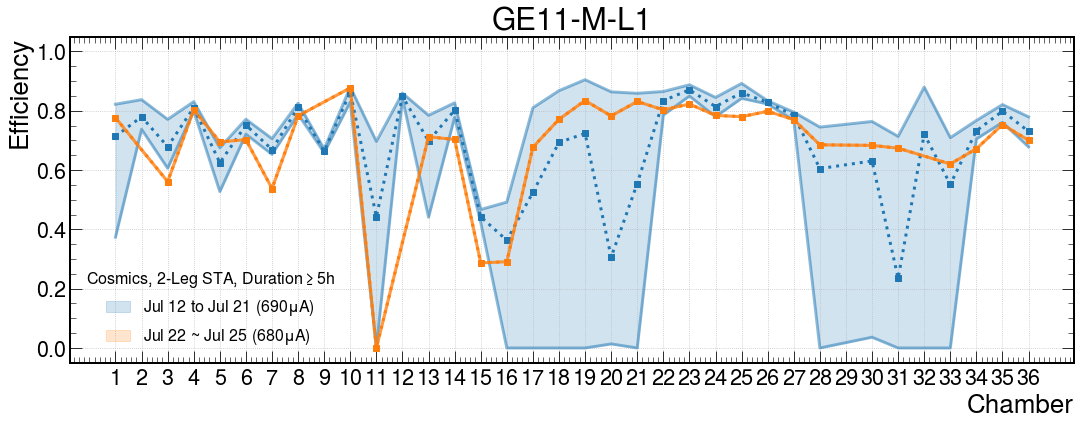

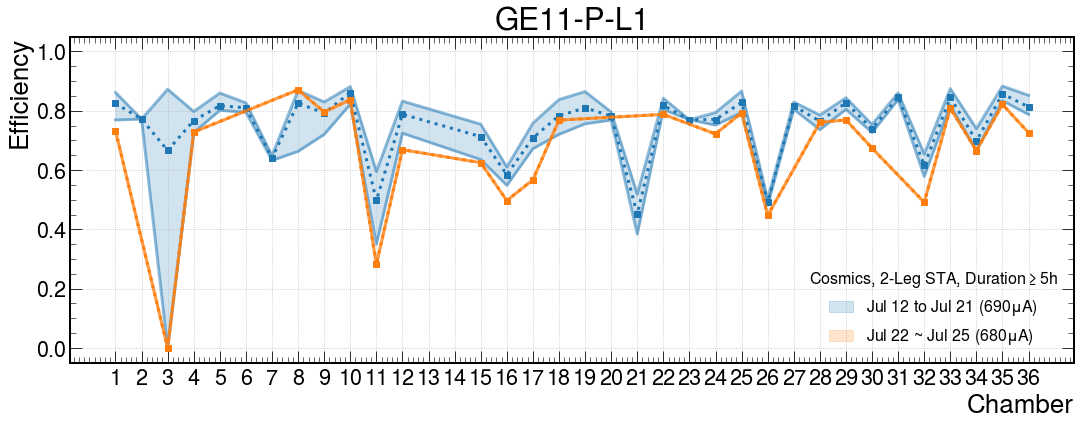

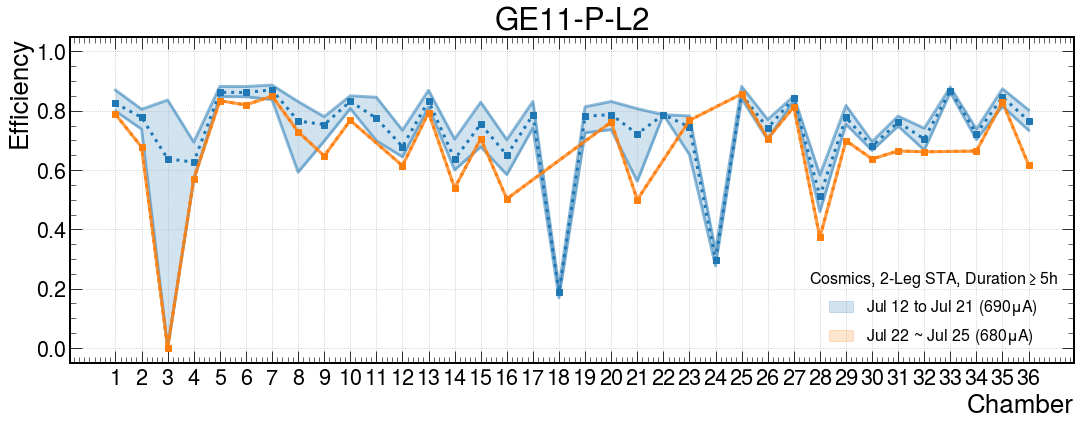

In [15]:
for region, layer in REGION_LAYER_LIST:
    fig, ax = plt.subplots(figsize=(18, 6), nrows=1)
    
    data = df[(df.region == region) & (df.layer == layer)]
    
    plot_fill_between(data[data.run < RUN_HV680_START], label="Jul 12 to Jul 21 (690$\mu$A)", color='tab:blue', ax=ax)
    plot_fill_between(data[data.run >= RUN_HV680_START], label="Jul 22 ~ Jul 25 (680$\mu$A)", color='tab:orange', ax=ax)

    _ = ax.set_xticks(range(1, NUM_CHAMBERS + 1))
    
    ax.set_xlabel("Chamber")
    ax.set_ylabel("Efficiency")
    
    title = make_title(region, layer)
    ax.set_title(title)
    
    legend_title = f"{data_path.stem}, 2-Leg STA, Duration$\geq${min_duration}h"
    ax.legend(title=legend_title, title_fontsize=16, fontsize=16)
    
    ax.grid()
    ax.set_ylim(-0.05, 1.05)
    
    plot_name = f"{data_path.stem}_{title}_duration-{min_duration}"
    plot_path = plot_dir.joinpath(plot_name).with_suffix(".png")
    
    fig.savefig(plot_path, bbox_inches="tight")